# Implement VGG-Net

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F 
#definisco rete più obsoleta than vgg
class LetNet(nn.Module):

  def __init__(self):
    super().__init__() #per richiamare costruttore
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):

    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)

    #passo da volume 4d a uno 2d con torch.flatten altrimenti pytorch strarompe il ca...
    x = torch.flatten(x, start_dim = 1) #mantengo batch->parto a flattenare la seconda dim (1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)





In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F 


class VGG16(nn.Module):

    def __init__(self, in_channels: int = 3, num_classes: int = 1000):
        super(VGG16, self).__init__()
        self.input_channels = in_channels
        self.output_channels = num_classes

        # suggestion: look into nn.Sequential() -> serve generatore di funzioni e non funzionne aka non va bene F.relu ma serve nn.ReLU()
        # and divide the convolutional feature extraction part of the net
        # from the final fully-connected classification part
        self.conv_features = nn.Sequential(
            
            #conv1 #224*224*3
            nn.Conv2d(in_channels = self.input_channels, out_channels=64,kernel_size = 3, padding = 'same'), # padding = 1 senno il kernel si mangia il resto
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels = 64 , kernel_size = 3 ,padding = 'same'),
            nn.ReLU(),

            nn.MaxPool2d(2), #112*112*64

            #conv2
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3,padding = 'same'), 
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3 , padding = 'same'), 
            nn.ReLU(),
            
            nn.MaxPool2d(2), # immm 56*56*128 

            #conv3
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size= 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size= 3, padding = 'same'),
            nn.ReLU(),

            nn.MaxPool2d(2), # immm 28*28*256

            #conv4
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size= 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size= 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size= 3, padding = 'same'),
            nn.ReLU(),

            nn.MaxPool2d(2), # immm 14*14*512

            #conv5
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size= 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size= 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size= 3, padding = 'same'),
            nn.ReLU(),

            nn.MaxPool2d(2), # immm 7*7*512
            nn.AdaptiveAvgPool2d((7, 7)) # serve per riadattare le immagini con size != 3x224x224
          )
          #devo flattenare imm 7*7*512 a vettore di 25088 features  da dare in ingresso alla NN 
        self.classifier = nn.Sequential(
          nn.Flatten(), #se uso torch,flatten(x) va messo in una funzione dove gli viene pasato il dato 
          nn.Linear(25088, 4096),
          nn.ReLU(),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Linear(4096, self.output_channels)        
        )

        # more self.stuff here...

    
    def forward(self, x):
        # code goes here for the forward function
        vgg = self.classifier(self.conv_features(x))
        return vgg

# Forward Pass Debug
If it can process random data, then you're mostly alright :D

In [ ]:
import numpy as np


net = VGG16(3, 1000)
print(net)
num_params = sum([np.prod(p.shape) for p in net.parameters()])
print(f"Number of parameters : {num_params}")
print('-'*50)

# test on Imagenet-like shaped data (224x224)

# X = torch.rand((8, 3, 224, 224))
# print('output shape for imgnet', net(X).shape)


In [ ]:
# test on CIFAR-like shaped data (32x32)

X = torch.rand((8, 3, 32, 32))
print('output shape for cifar', net(X).shape)

output shape for cifar torch.Size([8, 1000])


# OPTIONAL: Let's train on CIFAR-10

let's load the dataset

In [ ]:
import torchvision
import torchvision.transforms as transforms

# mean = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
# std  = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

# Choose the appropriate transforms for the problem at hand
# see https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=40,
                                         shuffle=False, num_workers=2)
n_total_step = len(trainloader)

print('total step:', n_total_step)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
total step: 1250


let's plot some sample images

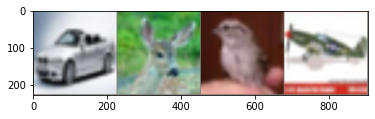

  car  deer  bird plane


In [ ]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img * np.array(std)[:,None,None] + np.array(mean)[:,None,None] # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
from torch.optim import SGD

assert torch.cuda.is_available(), "Notebook is not configured properly!"
print('Congrats, you\'re running this code on a', torch.cuda.get_device_name(), 'gpu')
device = 'cuda:0'

net = VGG16(3, 10).to(device) # initialize VGG16 for this specific classification problem

# Nothing works w/o Batch Norm or Proper Initialization perche per un motivo ignoto non sono inizializzati bene i pesi per fare trainning e con batch normalization 
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
initialize_weights(net)

# define here the Pytorch objects needed for training
crit = nn.CrossEntropyLoss().to(device) # loss criterion
learning_rate = 0.001 #learning_rate of SGD opt
opt = SGD(net.parameters(), learning_rate, momentum=0.9, weight_decay=5e-4) # optimizer
epochs = 10


Congrats, you're running this code on a Tesla T4 gpu


Training loop

In [ ]:
from torch.optim import SGD
from datetime import datetime
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt

for e in range(epochs):
    # magic progress bar printer
    pbar = tqdm(total=len(trainloader), desc=f'Epoch {e} - 0%')
    
    # training loop ->  
    for i, (x, y) in enumerate(trainloader):
      x, y = x.to(device), y.to(device)
      y_pred = net(x)
      n_corrects = (y_pred.argmax(axis=1) == y).sum().item()
      loss = crit(y_pred, y)
      loss.backward()
      opt.step()  
      opt.zero_grad()
        # logging functions
      pbar.update(1)
      pbar.set_description(f"Epoch {e} - {round(i/len(trainloader) * 100)}% -- loss {loss.item():.2f} -- "
                                f"acc = {100*(n_corrects/y.size(0)):.2f}%")
  
    # evaluation loop
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(testloader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = net(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')

    
    # print(f"Accuracy for epoch {e}:{corr / len(testset)}")

Epoch 0 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 6 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7 - 0%:   0%|          | 0/1250 [00:00<?, ?it/s]

# Test_1

learning_rate=0.001

batch_size = 64

Overall accuracy 70.99%